# Importing

In [1]:
!pip install niapy==2.6.0

In [2]:
!pip show numpy

Name: numpy
Version: 2.3.5
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2025, NumPy Developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are
 met:

     * Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.

     * Redistributions in binary form must reproduce the above
        copyright notice, this list of conditions and the following
        disclaimer in the documentation and/or other materials provided
        with the distribution.

     * Neither the name of the NumPy Developers nor the names of any
        contributors may be used to endorse or promote products derived
        from this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED

In [11]:
!python --version


Python 3.12.12


In [2]:
import os
import time
import json
import random
import numpy as np
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    Conv1D, BatchNormalization, InputLayer
)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.metrics import AUC

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import compute_class_weight

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from niapy.problems import Problem
from niapy.task import OptimizationType, Task
from niapy.algorithms.basic import MonarchButterflyOptimization


In [3]:
warnings.filterwarnings('ignore')  

In [4]:
random.seed(42)

np.random.seed(42)

tf.random.set_seed(42)

# Data Prep

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/adistyadito/LSTM-MBA/refs/heads/main/data/GSARPC3.csv')
df['smiles'] = df['smiles']

df['target'] = df['categories'].apply(lambda x: 1 if x == "inhibitor" else 0)
print("Distribusi label:")
print(df['target'].value_counts(normalize=True))

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['target']
)


Distribusi label:
target
0    0.504717
1    0.495283
Name: proportion, dtype: float64


# Preproc

In [6]:
import re

pattern = re.compile(
    r"(\[[^\]]*\]|Br|Cl|Si|Se|@@?|==?|##?|/|\\|\(|\)|\.|\+|\-|%\d\d|%\d|\d|[A-Z][a-z]?|[a-z])"
)

def tokenize(smiles):
    return pattern.findall(smiles)

all_tokens = []
for s in df['smiles']:
    toks = tokenize(s)
    all_tokens.extend(toks)

vocab = sorted(set(all_tokens))
token_to_int = {tok: i+1 for i, tok in enumerate(vocab)}
token_to_int['<PAD>'] = 0

vocab_size = len(token_to_int)
print("vocab_size:", vocab_size)


MAX_LEN = min(250, max(len(tokenize(s)) for s in df['smiles']) + 5)

def smiles_to_seq(smiles_list, max_len):
    seqs = []
    for s in smiles_list:
        toks = tokenize(s)
        seq = [token_to_int.get(t, 0) for t in toks]
        
        if len(seq) > max_len:
            seq = seq[:max_len]
        else:
            seq += [0] * (max_len - len(seq))  
        
        seqs.append(seq)
    return np.array(seqs, dtype=np.int32)

X_train = smiles_to_seq(df_train['smiles'].tolist(), MAX_LEN)
X_test  = smiles_to_seq(df_test['smiles'].tolist(), MAX_LEN)

y_train = df_train['target'].values.astype(np.float32)
y_test  = df_test['target'].values.astype(np.float32)

print(f"X_train: {X_train.shape} | vocab: {vocab_size} | max_len: {MAX_LEN}")


vocab_size: 27
X_train: (508, 168) | vocab: 27 | max_len: 168


In [7]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 0.9921875, 1: 1.007936507936508}


# Setup

## Decode Solution

In [8]:
def decode_solution(x):
    # x is assumed in [0,1]^5
    # n_layers: map x[0] -> {1,2,3}
    n_layers = int(1 + np.floor(x[0] * 3))  # x in [0,1): -> 1..3 ; if x==1 -> will give 4 so handle
    if n_layers > 3:
        n_layers = 3

    # units: map x[1..3] -> [16, 256] integer
    def map_units(v):
        return int(np.round(16 + v * (256 - 16)))  # 16..256
    u1 = map_units(x[1])
    u2 = map_units(x[2])
    u3 = map_units(x[3])

    # learning rate: exponent range [-4.0, -2.3]
    exp = -4.0 + x[4] * ( -2.3 - (-4.0) )  # = -4.0 + x[4] * 1.7
    exp = float(np.clip(exp, -4.0, -2.3))
    lr = float(10 ** exp)

    if n_layers == 1:
        units = (u1,)
    elif n_layers == 2:
        units = (u1, u2)
    else:
        units = (u1, u2, u3)

    return {
        'n_layers': n_layers,
        'units': units,
        'lr': lr
    }


## Build LSTM

In [9]:
# Fungsi untuk membangun model LSTM secara dinamis
def build_lstm_dynamic(params, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True))

    n_layers = params['n_layers']
    units = params['units']

    for i in range(n_layers):
        return_sequences = (i < n_layers - 1)
        model.add(LSTM(units[i], activation='tanh', return_sequences=return_sequences))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Problems

In [10]:
class LSTMHyperparameterOptimization(Problem):
    def __init__(self, X_train, y_train, X_val, y_val, vocab_size, max_epochs=50):
        # Dimensi solusi: n_layers, u1, u2, u3, lr
        super().__init__(dimension=5, lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.vocab_size = vocab_size
        self.max_epochs = max_epochs

    def _evaluate(self, x):
        # Decode solusi
        params = decode_solution(x)
        print("\n=== Evaluating Solution ===")
        print("Decoded params:", params)

        # Build model
        model = build_lstm_dynamic(params, self.vocab_size)
        optimizer = Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=0)

        try:
            history = model.fit(
                self.X_train, self.y_train,
                epochs=self.max_epochs,
                batch_size=16,
                validation_data=(self.X_val, self.y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )

            # Evaluasi
            val_loss, val_acc, val_auc = model.evaluate(self.X_val, self.y_val, verbose=0)

            print(f"Validation loss: {val_loss:.4f}, acc: {val_acc:.4f}, auc: {val_auc:.4f}")
            return val_loss

        except Exception as e:
            print(f"Error evaluating solution {x}: {e}")
            return float('inf')


# Model 1


=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (121, 222, 183), 'lr': 0.0001445777598804382}
Validation loss: 0.6090, acc: 0.6719, auc: 0.7244

=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (199, 205, 47), 'lr': 0.0005829832733955851}
Validation loss: 0.6007, acc: 0.6797, auc: 0.7336

=== Evaluating Solution ===
Decoded params: {'n_layers': 2, 'units': (238, 171), 'lr': 0.0005672887067955608}
Validation loss: 0.6089, acc: 0.6484, auc: 0.7242

=== Evaluating Solution ===
Decoded params: {'n_layers': 1, 'units': (149,), 'lr': 0.001185303259024286}
Validation loss: 0.5849, acc: 0.6719, auc: 0.7331

=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (101, 249, 230), 'lr': 0.0021049992480151147}
Validation loss: 0.5944, acc: 0.6562, auc: 0.7310

=== Evaluating Solution ===
Decoded params: {'n_layers': 1, 'units': (128,), 'lr': 0.0014493831915492381}
Validation loss: 0.5715, acc: 0.6719, auc: 0.7480

=== Evaluating Solution ===


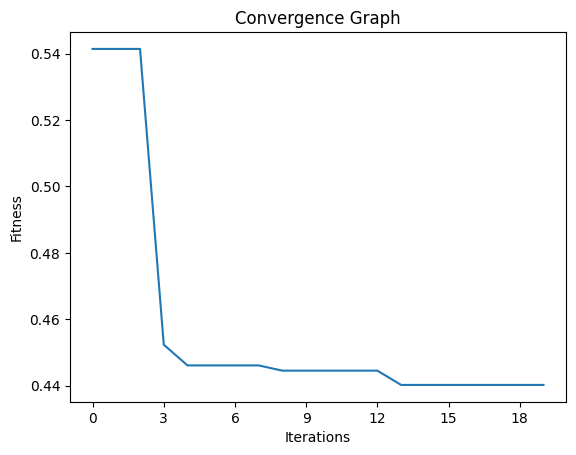

In [19]:
# Definisikan problem
problem = LSTMHyperparameterOptimization(X_train, y_train, X_test, y_test, vocab_size)

# Definisikan task (MINIMIZATION untuk loss)
task = Task(problem=problem, max_iters=20, optimization_type=OptimizationType.MINIMIZATION)

# Definisikan algoritma MBO
algo = MonarchButterflyOptimization(population_size=10, partition=5.0 / 12.0, period=1.2, seed=42)

# Jalankan optimasi
best_params_vector, best_loss = algo.run(task)

# Decode hasil terbaik
best_params = decode_solution(best_params_vector)

print('Best parameters found by MBO (minimizing loss):', best_params)
print('Best validation loss:', best_loss)

task.plot_convergence(x_axis='iters')

xmod1, ymod1 = task.convergence_data(x_axis='iters')

data_json = json.dumps({
    "evaluation": xmod1.tolist(),
    "fitness": ymod1.tolist()
})

In [20]:
best_params

{'n_layers': 1, 'units': (238,), 'lr': 0.003762707690406812}

In [24]:
data_json

'{"evaluation": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], "fitness": [0.5414547920227051, 0.5414547920227051, 0.5414547920227051, 0.45232731103897095, 0.44607415795326233, 0.44607415795326233, 0.44607415795326233, 0.44607415795326233, 0.4445011615753174, 0.4445011615753174, 0.4445011615753174, 0.4445011615753174, 0.4445011615753174, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385]}'

In [35]:
def build_model(vocab_size,
                embedding_dim=50,
                n_layers=1,
                units=(16,),
                dropout_rate=0.3,
                lr=0.001):
    
    model = Sequential()

    # ---- EMBEDDING ----
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    # ---- DYNAMIC LSTM STACK ----
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  
        model.add(LSTM(units[i], return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    # ---- DENSE ----
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # ---- COMPILE ----
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='AUC')]
    )

    return model


In [46]:
# Build model
model = build_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    dropout_rate=0.3,  # samain sama MBO
    lr=best_params['lr']
)



callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('fixed_model.keras', monitor='val_loss', mode='min', save_best_only=True)
]

# Fit model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # samain sama MBO
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.4344 - accuracy: 0.4708 - loss: 0.6973 - val_AUC: 0.5958 - val_accuracy: 0.6016 - val_loss: 0.6798 - learning_rate: 0.0038
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.5554 - accuracy: 0.5411 - loss: 0.7242 - val_AUC: 0.6090 - val_accuracy: 0.5078 - val_loss: 0.6840 - learning_rate: 0.0038
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.5690 - accuracy: 0.5408 - loss: 0.6921 - val_AUC: 0.6440 - val_accuracy: 0.5547 - val_loss: 0.6743 - learning_rate: 0.0038
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6062 - accuracy: 0.5978 - loss: 0.6847 - val_AUC: 0.6652 - val_accuracy: 0.6250 - val_loss: 0.6637 - learning_rate: 0.0038
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6200 - accuracy: 0.6146 - loss: 0.6830 - val_AUC: 0.6930 - val_accuracy: 0.6172 - val_loss: 0.6417 - learning_rate: 0.0038
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6582 - accuracy: 0.6262 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

=evaluation
ROC-AUC       : 0.8608
Akurasi       : 0.7578

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.76      0.77      0.76        65
   Inhibitor       0.76      0.75      0.75        63

    accuracy                           0.76       128
   macro avg       0.76      0.76      0.76       128
weighted avg       0.76      0.76      0.76       128



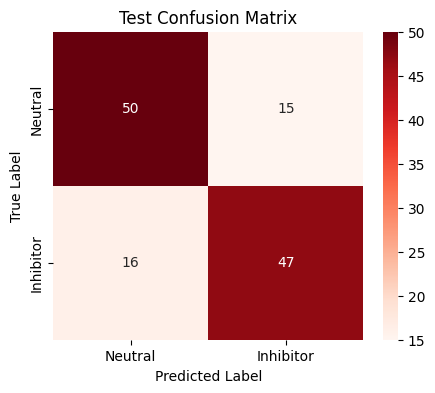

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


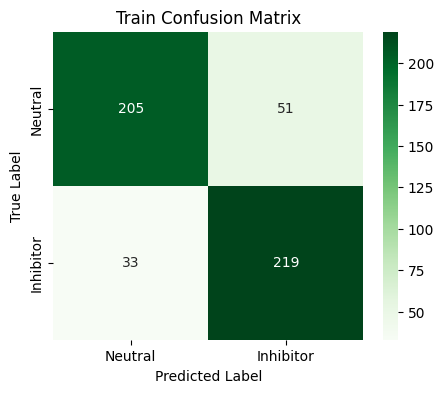

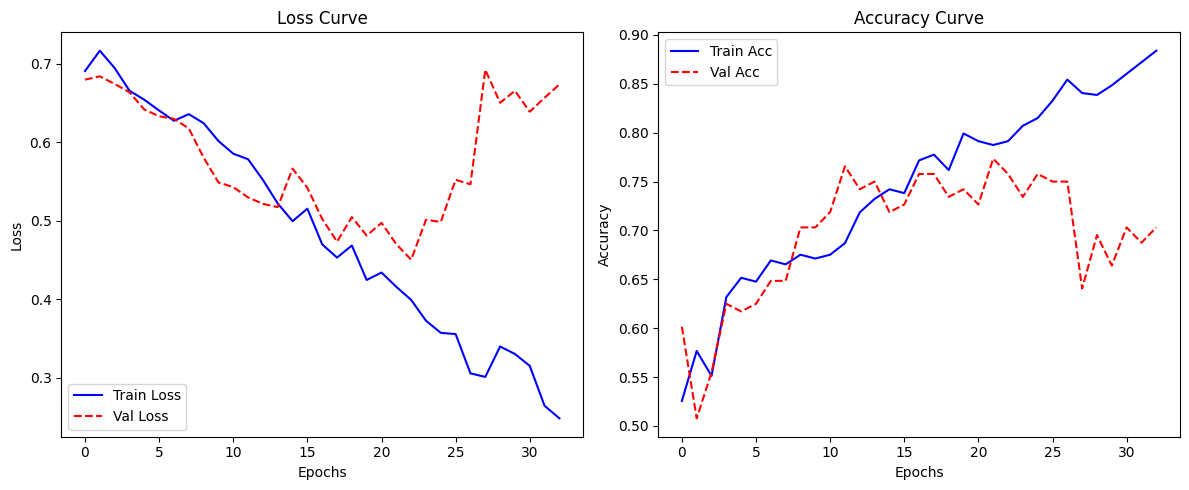

In [49]:
# ====== TEST CONFUSION MATRIX ======
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',  # <- ubah jadi merah
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = model.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()


def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    # ---- LOSS ----
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-')  # training biru
    plt.plot(history.history['val_loss'], label='Val Loss', color='red', linestyle='--')  # validation merah putus
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # ---- METRIC (AUC atau Accuracy) ----
    plt.subplot(1,2,2)
    if 'auc' in history.history:
        plt.plot(history.history['auc'], label='Train AUC', color='blue', linestyle='-')
        plt.plot(history.history['val_auc'], label='Val AUC', color='red', linestyle='--')
        plt.title('ROC-AUC Curve')
        plt.ylabel('AUC')
    else:
        plt.plot(history.history['accuracy'], label='Train Acc', color='blue', linestyle='-')
        plt.plot(history.history['val_accuracy'], label='Val Acc', color='red', linestyle='--')
        plt.title('Accuracy Curve')
        plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)



In [50]:
import pandas as pd

# history.history itu dictionary {metric_name: [list of values per epoch]}
history_df = pd.DataFrame(history.history)

# simpan ke CSV
history_df.to_csv("training_history.csv", index=False)

print("Training history saved to training_history.csv")


Training history saved to training_history.csv


In [52]:
history_df

,AUC,accuracy,loss,val_AUC,val_accuracy,val_loss,learning_rate
0,0.539721,0.525591,0.690720,0.595849,0.601562,0.679758,0.003763
1,0.589821,0.576772,0.716642,0.609035,0.507812,0.684002,0.003763
2,0.577451,0.551181,0.694532,0.643956,0.554688,0.674283,0.003763
3,0.647957,0.631890,0.665618,0.665201,0.625000,0.663717,0.003763
4,0.664489,0.651575,0.654144,0.693040,0.617188,0.641668,0.003763
5,0.685121,0.647638,0.640394,0.706349,0.625000,0.633092,0.003763
6,0.706310,0.669291,0.627323,0.717460,0.648438,0.629762,0.003763
7,0.696584,0.665354,0.635786,0.741392,0.648438,0.617587,0.003763
8,0.708023,0.675197,0.624273,0.754823,0.703125,0.580481,0.003763
9,0.732468,0.671260,0.601583,0.785958,0.703125,0.548744,0.003763


# Model 2


=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (121, 222, 183), 'lr': 0.0001445777598804382}
Validation loss: 0.6043, acc: 0.6797, auc: 0.7381

=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (199, 205, 47), 'lr': 0.0005829832733955851}
Validation loss: 0.6044, acc: 0.6719, auc: 0.7266

=== Evaluating Solution ===
Decoded params: {'n_layers': 2, 'units': (238, 171), 'lr': 0.0005672887067955608}
Validation loss: 0.6051, acc: 0.6953, auc: 0.7244

=== Evaluating Solution ===
Decoded params: {'n_layers': 1, 'units': (149,), 'lr': 0.001185303259024286}
Validation loss: 0.5789, acc: 0.7031, auc: 0.7568

=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (101, 249, 230), 'lr': 0.0021049992480151147}
Validation loss: 0.6010, acc: 0.6484, auc: 0.7156

=== Evaluating Solution ===
Decoded params: {'n_layers': 1, 'units': (128,), 'lr': 0.0014493831915492381}
Validation loss: 0.6067, acc: 0.5781, auc: 0.7012

=== Evaluating Solution ===


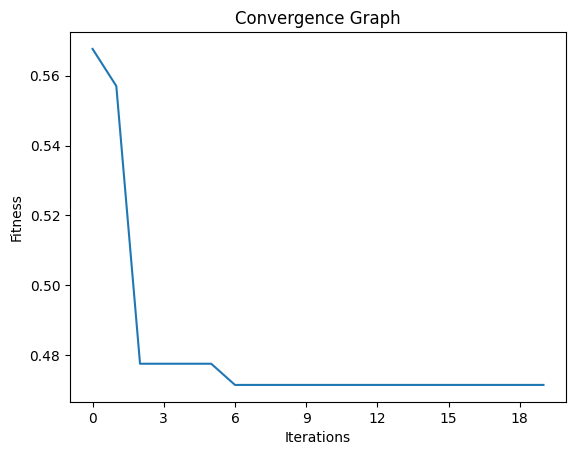

In [53]:
# Definisikan problem
problem = LSTMHyperparameterOptimization(X_train, y_train, X_test, y_test, vocab_size)

# Definisikan task (MINIMIZATION untuk loss)
task = Task(problem=problem, max_iters=20, optimization_type=OptimizationType.MINIMIZATION)

# Definisikan algoritma MBO
algo = MonarchButterflyOptimization(population_size=15, partition=5.0 / 12.0, period=1.2, seed=42)

# Jalankan optimasi
best_params_vector, best_loss = algo.run(task)

# Decode hasil terbaik
best_params = decode_solution(best_params_vector)

print('Best parameters found by MBO (minimizing loss):', best_params)
print('Best validation loss:', best_loss)

task.plot_convergence(x_axis='iters')

xmod2, ymod2 = task.convergence_data(x_axis='iters')

data_json_2 = json.dumps({
    "evaluation": xmod2.tolist(),
    "fitness": ymod2.tolist()
})

In [54]:
best_params

{'n_layers': 2, 'units': (256, 216), 'lr': 0.005011872336272725}

In [55]:
data_json_2

'{"evaluation": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], "fitness": [0.567677915096283, 0.5570561289787292, 0.4775429368019104, 0.4775429368019104, 0.4775429368019104, 0.4775429368019104, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129]}'

In [56]:
def build_model(vocab_size,
                embedding_dim=50,
                n_layers=1,
                units=(16,),
                dropout_rate=0.3,
                lr=0.001):
    
    model2 = Sequential()

    # ---- EMBEDDING ----
    model2.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    # ---- DYNAMIC LSTM STACK ----
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  
        model2.add(LSTM(units[i], return_sequences=return_seq))
        model2.add(Dropout(dropout_rate))

    # ---- DENSE ----
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(dropout_rate))
    model2.add(Dense(1, activation='sigmoid'))

    # ---- COMPILE ----
    model2.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='AUC')]
    )

    return model2


In [67]:
# Build model
model2 = build_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    dropout_rate=0.3,  # samain sama MBO
    lr=best_params['lr']
)



callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('fixed_model.keras', monitor='val_loss', mode='min', save_best_only=True)
]
    
# Fit model
history = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # samain sama MBO
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - AUC: 0.4266 - accuracy: 0.4851 - loss: 0.7152 - val_AUC: 0.4868 - val_accuracy: 0.5547 - val_loss: 0.6940 - learning_rate: 0.0050
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - AUC: 0.5237 - accuracy: 0.5126 - loss: 0.6919 - val_AUC: 0.5812 - val_accuracy: 0.5078 - val_loss: 0.6867 - learning_rate: 0.0050
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - AUC: 0.5006 - accuracy: 0.4886 - loss: 0.7432 - val_AUC: 0.5339 - val_accuracy: 0.5391 - val_loss: 0.7050 - learning_rate: 0.0050
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.4414 - accuracy: 0.4730 - loss: 0.7537 - val_AUC: 0.5515 - val_accuracy: 0.5078 - val_loss: 0.6949 - learning_rate: 0.0050
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - AUC: 0.4207 - accuracy: 0.4320 - loss: 0.7284 - val_AUC: 0.6138 - val_accuracy: 0.5078 - val_loss: 0.7023 - learning_rate: 0.0050
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.4297 - accuracy: 0.4590 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

=evaluation
ROC-AUC       : 0.8181
Akurasi       : 0.7578

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.77      0.74      0.76        65
   Inhibitor       0.74      0.78      0.76        63

    accuracy                           0.76       128
   macro avg       0.76      0.76      0.76       128
weighted avg       0.76      0.76      0.76       128



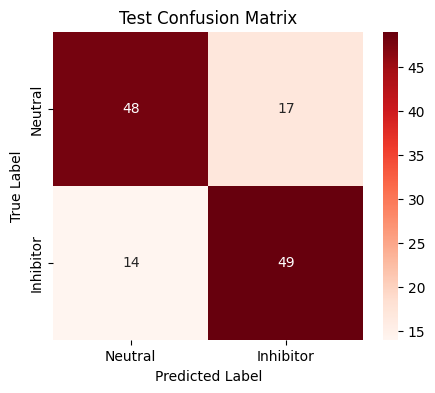

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


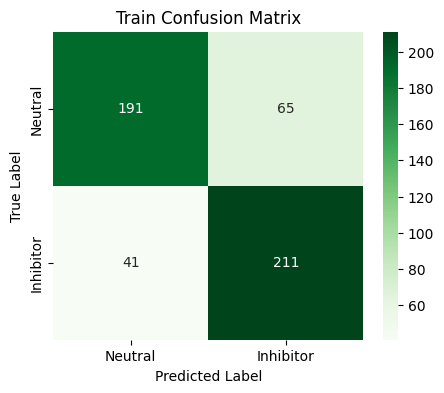

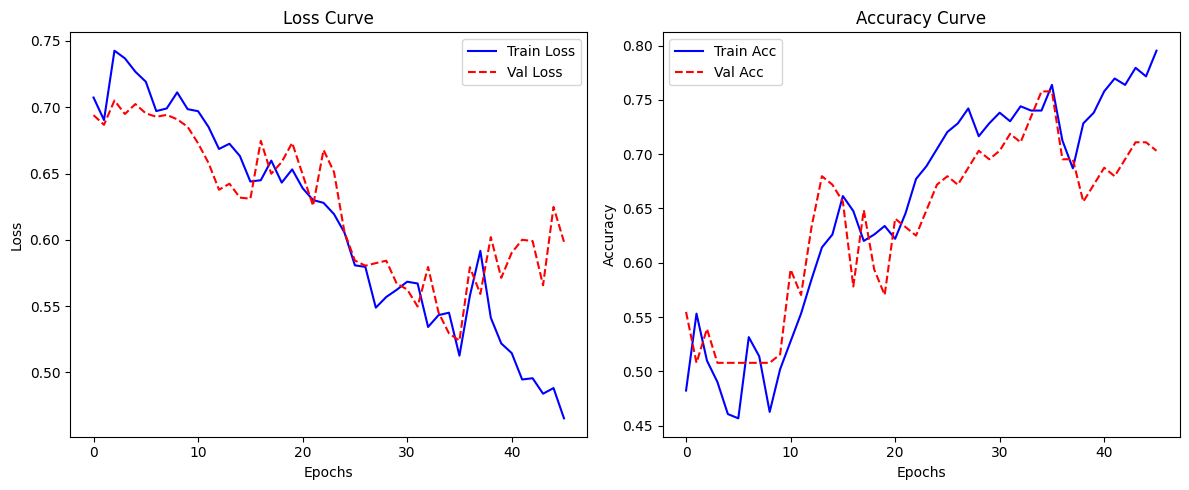

In [68]:
# ====== TEST CONFUSION MATRIX ======
y_pred_prob = model2.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',  # <- ubah jadi merah
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = model2.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()


def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    # ---- LOSS ----
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-')  # training biru
    plt.plot(history.history['val_loss'], label='Val Loss', color='red', linestyle='--')  # validation merah putus
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # ---- METRIC (AUC atau Accuracy) ----
    plt.subplot(1,2,2)
    if 'auc' in history.history:
        plt.plot(history.history['auc'], label='Train AUC', color='blue', linestyle='-')
        plt.plot(history.history['val_auc'], label='Val AUC', color='red', linestyle='--')
        plt.title('ROC-AUC Curve')
        plt.ylabel('AUC')
    else:
        plt.plot(history.history['accuracy'], label='Train Acc', color='blue', linestyle='-')
        plt.plot(history.history['val_accuracy'], label='Val Acc', color='red', linestyle='--')
        plt.title('Accuracy Curve')
        plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)



# Model 3


=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (121, 222, 183), 'lr': 0.0001445777598804382}
Validation loss: 0.6228, acc: 0.6328, auc: 0.7155

=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (199, 205, 47), 'lr': 0.0005829832733955851}
Validation loss: 0.5850, acc: 0.6562, auc: 0.7422

=== Evaluating Solution ===
Decoded params: {'n_layers': 2, 'units': (238, 171), 'lr': 0.0005672887067955608}
Validation loss: 0.6073, acc: 0.6562, auc: 0.7264

=== Evaluating Solution ===
Decoded params: {'n_layers': 1, 'units': (149,), 'lr': 0.001185303259024286}
Validation loss: 0.5935, acc: 0.6875, auc: 0.7278

=== Evaluating Solution ===
Decoded params: {'n_layers': 3, 'units': (101, 249, 230), 'lr': 0.0021049992480151147}
Validation loss: 0.6191, acc: 0.6875, auc: 0.7247

=== Evaluating Solution ===
Decoded params: {'n_layers': 1, 'units': (128,), 'lr': 0.0014493831915492381}
Validation loss: 0.5997, acc: 0.7031, auc: 0.7237

=== Evaluating Solution ===


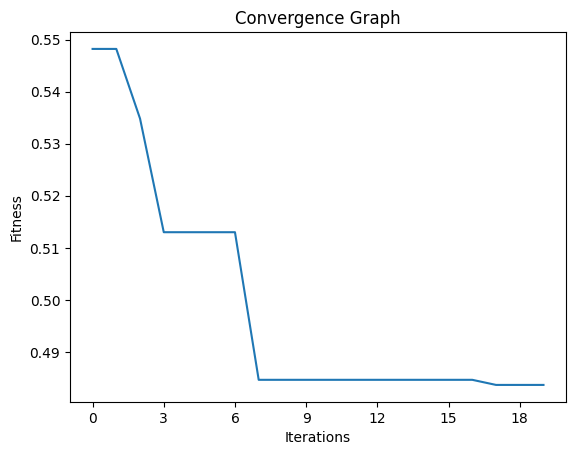

In [11]:
# Definisikan problem
problem = LSTMHyperparameterOptimization(X_train, y_train, X_test, y_test, vocab_size)

# Definisikan task (MINIMIZATION untuk loss)
task = Task(problem=problem, max_iters=20, optimization_type=OptimizationType.MINIMIZATION)

# Definisikan algoritma MBO
algo = MonarchButterflyOptimization(population_size=20, partition=5.0 / 12.0, period=1.2, seed=42)

# Jalankan optimasi
best_params_vector, best_loss = algo.run(task)

# Decode hasil terbaik
best_params = decode_solution(best_params_vector)

print('Best parameters found by MBO (minimizing loss):', best_params)
print('Best validation loss:', best_loss)

task.plot_convergence(x_axis='iters')

xmod3, ymod3 = task.convergence_data(x_axis='iters')

data_json_3 = json.dumps({
    "evaluation": xmod3.tolist(),
    "fitness": ymod3.tolist()
})

In [12]:
best_params

{'n_layers': 1, 'units': (121,), 'lr': 0.005011872336272725}

In [14]:
data_json_3

'{"evaluation": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], "fitness": [0.5482057929039001, 0.5482057929039001, 0.5348204374313354, 0.5130017399787903, 0.5130017399787903, 0.5130017399787903, 0.5130017399787903, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.4836696684360504, 0.4836696684360504, 0.4836696684360504]}'

In [15]:
def build_model(vocab_size,
                embedding_dim=50,
                n_layers=1,
                units=(16,),
                dropout_rate=0.3,
                lr=0.001):
    
    model3 = Sequential()

    # ---- EMBEDDING ----
    model3.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    # ---- DYNAMIC LSTM STACK ----
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  
        model3.add(LSTM(units[i], return_sequences=return_seq))
        model3.add(Dropout(dropout_rate))

    # ---- DENSE ----
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(dropout_rate))
    model3.add(Dense(1, activation='sigmoid'))

    # ---- COMPILE ----
    model3.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='AUC')]
    )

    return model3


In [20]:
# Build model
model3 = build_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    dropout_rate=0.3,  # samain sama MBO
    lr=best_params['lr']
)



callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('fixed_model.keras', monitor='val_loss', mode='min', save_best_only=True)
]
    
# Fit model
history = model3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # samain sama MBO
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 0.4487 - accuracy: 0.4292 - loss: 0.6964 - val_AUC: 0.6320 - val_accuracy: 0.6328 - val_loss: 0.6726 - learning_rate: 0.0050
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.6050 - accuracy: 0.5716 - loss: 0.6850 - val_AUC: 0.6392 - val_accuracy: 0.6484 - val_loss: 0.6659 - learning_rate: 0.0050
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.6443 - accuracy: 0.6218 - loss: 0.6594 - val_AUC: 0.7017 - val_accuracy: 0.6094 - val_loss: 0.6265 - learning_rate: 0.0050
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.5255 - accuracy: 0.5244 - loss: 0.8000 - val_AUC: 0.6248 - val_accuracy: 0.5859 - val_loss: 0.6757 - learning_rate: 0.0050
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6021 - accuracy: 0.5618 - loss: 0.6766 - val_AUC: 0.6534 - val_accuracy: 0.6562 - val_loss: 0.6656 - learning_rate: 0.0050
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.6361 - accuracy: 0.6293 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

=evaluation
ROC-AUC       : 0.8295
Akurasi       : 0.7812

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.75      0.86      0.80        65
   Inhibitor       0.83      0.70      0.76        63

    accuracy                           0.78       128
   macro avg       0.79      0.78      0.78       128
weighted avg       0.79      0.78      0.78       128



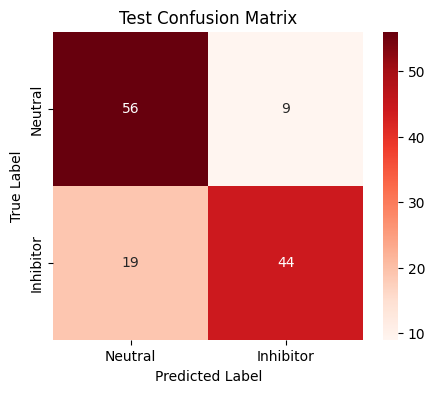

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


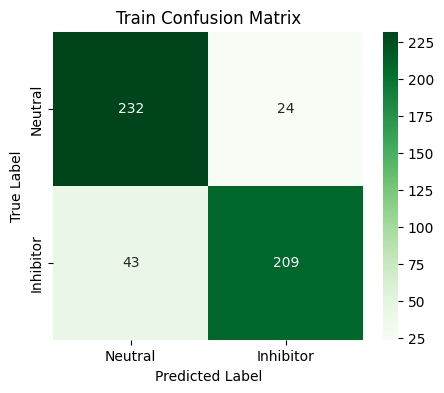

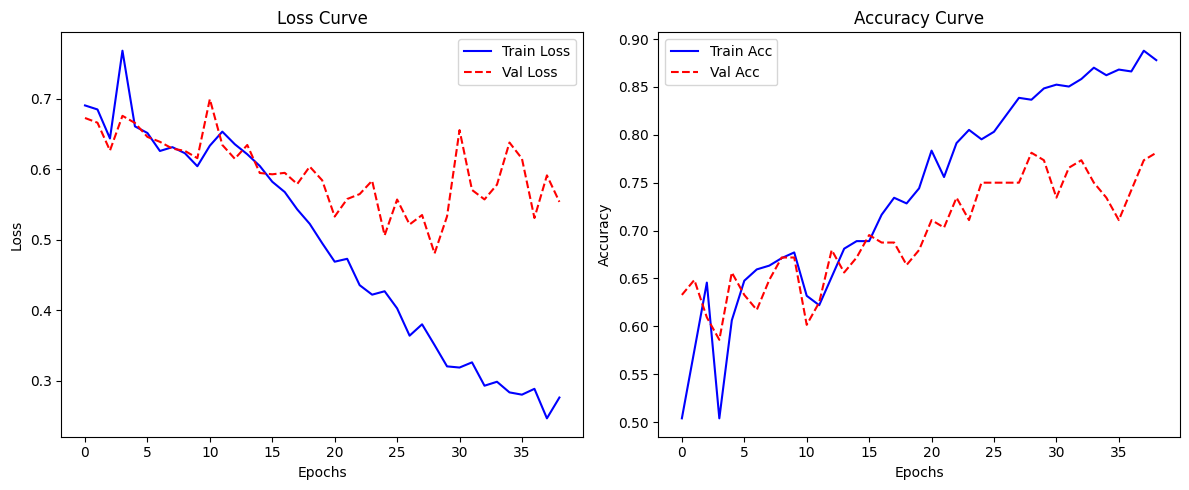

In [21]:
# ====== TEST CONFUSION MATRIX ======
y_pred_prob = model3.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',  # <- ubah jadi merah
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = model3.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()


def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    # ---- LOSS ----
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-')  # training biru
    plt.plot(history.history['val_loss'], label='Val Loss', color='red', linestyle='--')  # validation merah putus
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # ---- METRIC (AUC atau Accuracy) ----
    plt.subplot(1,2,2)
    if 'auc' in history.history:
        plt.plot(history.history['auc'], label='Train AUC', color='blue', linestyle='-')
        plt.plot(history.history['val_auc'], label='Val AUC', color='red', linestyle='--')
        plt.title('ROC-AUC Curve')
        plt.ylabel('AUC')
    else:
        plt.plot(history.history['accuracy'], label='Train Acc', color='blue', linestyle='-')
        plt.plot(history.history['val_accuracy'], label='Val Acc', color='red', linestyle='--')
        plt.title('Accuracy Curve')
        plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)



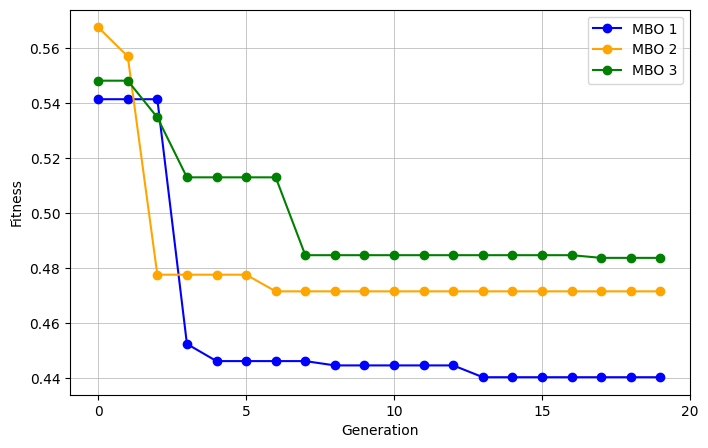

In [23]:
import matplotlib.pyplot as plt

# Data
evals = list(range(20))
mbo1 = [0.5414547920227051, 0.5414547920227051, 0.5414547920227051, 0.45232731103897095, 0.44607415795326233,
        0.44607415795326233, 0.44607415795326233, 0.44607415795326233, 0.4445011615753174, 0.4445011615753174,
        0.4445011615753174, 0.4445011615753174, 0.4445011615753174, 0.44020044803619385, 0.44020044803619385,
        0.44020044803619385, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385, 0.44020044803619385]

mbo2 = [0.567677915096283, 0.5570561289787292, 0.4775429368019104, 0.4775429368019104, 0.4775429368019104,
        0.4775429368019104, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129,
        0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129,
        0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129, 0.4714778959751129]

mbo3 = [0.5482057929039001, 0.5482057929039001, 0.5348204374313354, 0.5130017399787903, 0.5130017399787903,
        0.5130017399787903, 0.5130017399787903, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694,
        0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694, 0.48464980721473694,
        0.48464980721473694, 0.48464980721473694, 0.4836696684360504, 0.4836696684360504, 0.4836696684360504]

plt.figure(figsize=(8, 5))

plt.plot(evals, mbo1, marker='o', label='MBO 1', color='blue')
plt.plot(evals, mbo2, marker='o', label='MBO 2', color='orange')
plt.plot(evals, mbo3, marker='o', label='MBO 3', color='green')

plt.xlabel("Generation")
plt.ylabel("Fitness")

# Custom x-ticks: 0, 5, 10, 15, 20
plt.xticks([0, 5, 10, 15, 20])

# Add grid with "boxed" appearance
plt.grid(True, which='both', linestyle='-', linewidth=0.5)

plt.legend()
plt.show()
